<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=165Y4f9iyXtcoxHyPmBS6qu0zJ5ppwe-8">
</p>

# Setting Up

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/My\ Drive/KagglePUBG

/content/drive/My Drive/KagglePUBG


In [0]:
!pip install ipython-autotime

In [0]:
# Memory saving function::: credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [0]:
def draw_hist(col_name, num_bin=10):
    title_name = col_name[0].upper() + col_name[1:]
    f, ax = plt.subplots()
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    ax.set_yscale('log')
    train.hist(column=col_name,ax=ax,bins=num_bin)
    plt.title('Histogram of ' + title_name)
    tmp = train[col_name].value_counts().sort_values(ascending=False)

In [0]:
def draw_boxplot(feature):
  sns.set(style="whitegrid")
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 4)
  ax =sns.boxplot(x=train[feature])

# Load

In [0]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

%matplotlib inline
%load_ext autotime

In [0]:
train=pd.read_csv("train_V2.csv.zip")
train=reduce_mem_usage(train)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
time: 30.7 s


# Feature Engineering

## Removing Missing Values

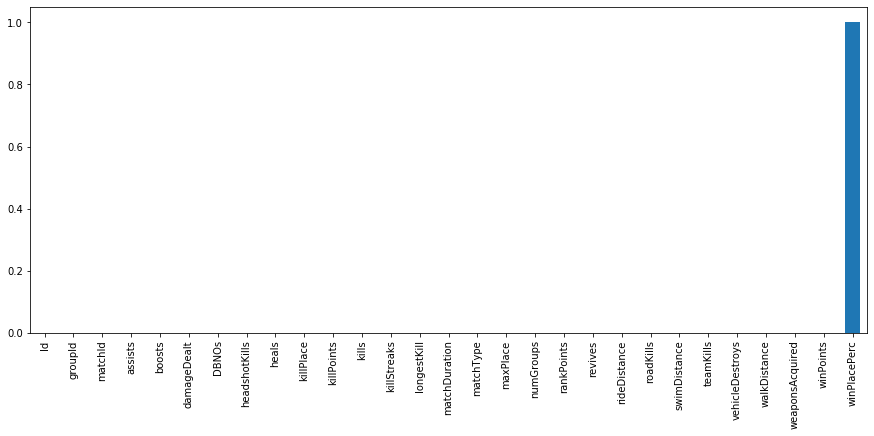

time: 1.51 s


In [0]:
# Visualize missing values
train.isna().sum().plot(kind='bar', figsize=(15,6))
plt.show()

In [0]:
### Drop NaNs ::: Add to final code
train.dropna(inplace=True)
train.reset_index(inplace=True,drop=True)

time: 1.78 s


In [0]:
print("NaNs in winPlacePerc after remove NaN : {}".format(train.winPlacePerc.isna().sum()))

NaNs in winPlacePerc after remove NaN : 0
time: 30.2 ms


## Feature Aggregation & New Feature Creation

In [0]:
def create_new_features(train): 
  # create new feature players Joined
  train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
  
  # create new feature member count
  train['memberCount'] = train.groupby('groupId')['groupId'].transform('count')
  
  # create Aggregated feature totalDistance (Only for anomaly detection purpose)
  train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
  
  # Create Aggregated feature healsandboosts
  train['healsandboosts'] = train['heals'] + train['boosts']
    
  # Create Aggregated feature teamWork
  train['teamWork'] = train['assists'] + train['revives']

  # Create Aggregated feature teamWork
  train["skill"] = train["headshotKills"] + train["roadKills"]

  # Create Aggregated feature killandrankpoints (Replace -1 which stands for none with 0 beforehand)
  train.loc[(train['rankPoints']==-1), 'rankPoints'] = 0
  train.loc[(train['winPoints']==-1), 'winPoints'] = 0
  train['EloRankpoints'] = train['rankPoints']+train['killPoints']+train['winPoints']

  # Percent of total heals by the team in the match                                   ########### I corrected
  train['totalHealsBoosts'] = train.groupby('groupId')['healsandboosts'].transform('sum') + train.groupby('matchId')['healsandboosts'].transform('sum')
  
  # Create headshot_rate feature
  train['headshot_rate'] =  train['kills'] /train['headshotKills']
  train['headshotKills_over_kills'] = train['headshotKills'] / train['kills']         ########### why 2???
  
  # Create Domain Specific features
  train['killStreakrate'] = train['killStreaks']/train['kills']
  train['killsOverWalkDistance'] = train['kills'] / train['walkDistance']
  train['killPlaceOverMaxPlace'] = train['killPlace'] / train['maxPlace']
  train['distance_over_weapons'] = train['totalDistance'] / train['weaponsAcquired']
  train['walkDistance_over_heals'] = train['walkDistance'] / train['heals']
  train['walkDistance_over_kills'] = train['walkDistance'] / train['kills']
  train['killsPerWalkDistance'] = train['kills'] / train['walkDistance']

  # Handle division by zero and division of zero in above steps
  train[train == np.Inf] = np.NaN
  train[train == np.NINF] = np.NaN
  train.fillna(0, inplace=True)

  return train

time: 27 ms


In [0]:
train = reduce_mem_usage(create_new_features(train))

Memory usage of dataframe is 606.46 MB
Memory usage after optimization is: 411.37 MB
Decreased by 32.2%
time: 33.4 s


## Removing Anomalies

### Kills without moving

In [0]:
print("{} players killed enemies without moving an inch".format(train[((train['kills'] > 0) & (train['totalDistance'] == 0))].shape[0]))

1535 players killed enemies without moving an inch
time: 217 ms


**Those 1535 players seems to be cheaters. Should be removed**

### Anomalies in Health Supplies

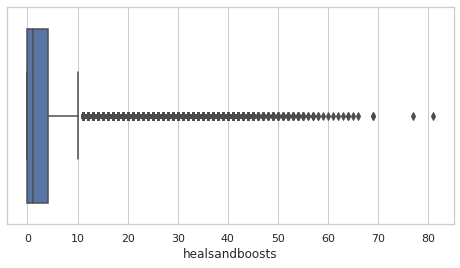

time: 1.19 s


In [0]:
draw_boxplot('healsandboosts')

In [0]:
print("Only {} players ({:.4f}%) have more than 30 heals or boosts".format(train[train['healsandboosts']>30].shape[0], train[train['healsandboosts']>30].shape[0]/train.shape[0]*100))

Only 1784 players (0.0401%) have more than 30 heals or boosts
time: 21.3 ms


**Can remove players who acquire more than 30 health items**

### Anomalies in Road Kills

In [0]:
# Players who got more than 10 roadKills
df = train[train['roadKills'] > 10]
df[['Id', 'roadKills', 'kills', 'rideDistance']]

,Id,roadKills,kills,rideDistance
2733926,c3e444f7d1289f,14,14,0.005001
2767998,34193085975338,11,11,4120.000000
2890739,a3438934e3e535,18,20,2726.000000
3524412,9d9d044f81de72,11,18,6812.000000


time: 27.6 ms


* **Player with ID c3e444f7d1289f	drove only 5 meters but killed 14 players. Seems something fishy. Definitely have to remove!**

* **Other 3 players can be either cheaters or exceptionally pro players (Outliers). So we can remove them as well.**

In [0]:
del df
gc.collect()

8065

time: 72 ms


### Anomalies in Headshot Rate

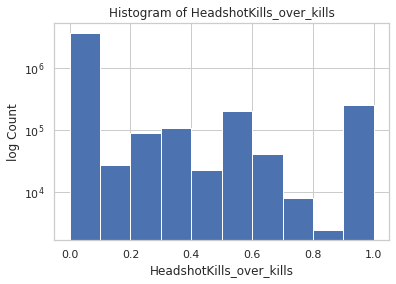

time: 1.35 s


In [0]:
draw_hist('headshotKills_over_kills')

In [0]:
headshot_perfection = train[(train['headshot_rate'] == 1) & (train['kills'] > 10)]
print("{} players ({:.4f}%) have 100% headshotKills_over_kills with more than 10 kills".format(headshot_perfection.shape[0], headshot_perfection.shape[0]/train.shape[0]*100))

13 players (0.0003%) have 100% headshotKills_over_kills with more than 10 kills
time: 80.1 ms


**Those 13 players seems to be cheating! Should be removed**

In [0]:
del headshot_perfection
gc.collect()

5655

time: 73.4 ms


### Anomalies in Team Kills

Team kills mean number of times player killed a team mate. As we saw in Feature Exploration, we got team kills more than 3. But only 3 members(max) are in a team except for the player in any main stream mode. Therefore all team kills higher than 3 can be considered as Anomalies

In [0]:
print("{} players have more than 3 team kills".format(train[train['teamKills'] > 3].shape[0]))

94 players have more than 3 team kills
time: 12.4 ms


### Zombies
Event mode

In [0]:
zombies = train.query('walkDistance == 0 & kills == 0 & weaponsAcquired == 0 & \'solo\' in matchType')
print("{} players ({:.4f}%) seems to be playing in zombie mode".format(zombies.shape[0], zombies.shape[0]/train.shape[0]*100))

5853 players (0.1316%) seems to be playing in zombie mode
time: 193 ms


**We should remove those 5853 zombies**

In [0]:
del zombies
gc.collect()

37

time: 68.7 ms


### Final Code for Removing Anomalies

In [0]:
def remove_anomalies(train):
  # Remove kills Without Moving
  train.drop(train[((train['kills'] > 0) & (train['totalDistance'] == 0))].index, inplace=True)
  # Remove road kills anomalies
  train.drop(train[train['roadKills'] > 10].index, inplace=True)
  # Remove headshot rate anomalies
  train.drop(train[(train['headshotKills_over_kills'] == 1) & (train['kills'] > 10)].index, inplace=True)
  # Remove heals and boosts anomalies
  train.drop(train[train['healsandboosts']>30].index, inplace=True)
  # Remove team kills which are more than 3
  train.drop(train[train['teamKills'] >3].index, inplace=True)
  # Remove Zombies
  train.drop(train.query('walkDistance == 0 & kills == 0 & weaponsAcquired == 0 & \'solo\' in matchType').index,inplace=True)
  # Remove groups with more than 4 members since those belongs to event modes
  train.drop(train[train['memberCount'] > 4].index, inplace=True)
  return train

time: 18.2 ms


In [0]:
train = reduce_mem_usage(remove_anomalies(train))

Memory usage of dataframe is 371.08 MB
Memory usage after optimization is: 371.08 MB
Decreased by 0.0%
time: 10.4 s


## Removing Outliers

In [0]:
def remove_outlier(train):
  # Remove kills more than 30 (95 players)
  train.drop(train[train['kills'] > 30].index, inplace=True)

  # Remove kill distance more than 1km 
  train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

  # Remove enemy knock out more than 20
  train.drop(train[train['DBNOs'] >20].index, inplace=True)

  # Remove kill streak more than 10
  train.drop(train[train['killStreaks'] >10].index, inplace=True)

  # Remove assists to kill more than 10
  train.drop(train[train['assists'] >10].index, inplace=True)

  # Remove distance based outliers 
  train.drop(train[train['walkDistance'] >10000.0].index, inplace=True)
  train.drop(train[train['rideDistance'] >15000.0].index, inplace=True)
  train.drop(train[train['swimDistance'] >1000.0].index, inplace=True)

  # Remove players that acquired more than 80 weapons in a match
  train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

  # Remove vehicle destroys more than 2
  train.drop(train[train['vehicleDestroys'] >2].index, inplace=True)

  # Remove revives more than 5
  train.drop(train[train['revives'] >5].index, inplace=True)

  return train

time: 19.6 ms


In [0]:
train = reduce_mem_usage(remove_outlier(train))

Memory usage of dataframe is 370.93 MB
Memory usage after optimization is: 367.40 MB
Decreased by 1.0%
time: 13.4 s


## Normalization & Scaling

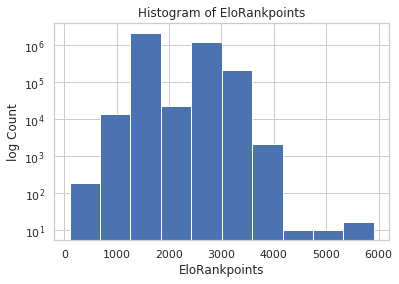

time: 752 ms


In [0]:
draw_hist('EloRankpoints')

**Need Scaling**

In [0]:
def normalize(train):
  ############# Normalization based on match (rank as percent)

  match=train.groupby('matchId')

  # Weapons acquired / Total Weapons in the match
  train['weaponsAcquiredPerc'] = match['weaponsAcquired'].rank(pct=True).values

  # Kills / Total Kills in the match
  train['killPerc'] = match['kills'].rank(pct=True).values

  # Percentage of kill place in the match that the player gets
  train['killPlacePerc'] = match['killPlace'].rank(pct=True).values
  # Percentage of total damagedealt in the match that the player gets
  train['damageDealt'] = match['damageDealt'].rank(pct=True).values
  # Percentage of total knocks in the match that the player gets
  train['DBNOsPerc'] = match['DBNOs'].rank(pct=True).values

  # Percent of total kills by the team in the match
  train['totalKillsByTeamPerc'] = train.groupby('groupId')['kills'].transform('sum') / match['kills'].transform('sum')

  # Walk Distance / Total Walk Distance in the match
  train['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
  # Ride Distance / Total Ride Distance in the match
  train['rideDistancePerc'] = match['rideDistance'].rank(pct=True).values
  # Swim Distance / Total Swim Distance in the match
  train['swimDistancePerc'] = match['swimDistance'].rank(pct=True).values

  train['walkPercPerkillsPerc'] = train['walkDistancePerc'] / train['killPerc']
 
  ############# Normalization based on playersJoined
  train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)

  ############# Handle division by zero and division of zero in above steps
  train[train == np.Inf] = np.NaN
  train[train == np.NINF] = np.NaN
  train.fillna(0, inplace=True)

  ############# Scaling of EloRankpoints
  train['EloRankpoints'] = MinMaxScaler().fit_transform(train['EloRankpoints'].to_numpy().reshape(-1,1))

  return train

time: 25.6 ms


In [0]:
train = reduce_mem_usage(normalize(train))

Memory usage of dataframe is 692.40 MB
Memory usage after optimization is: 438.05 MB
Decreased by 36.7%
time: 56.5 s


## Handling the categorical values

In [0]:
def categorical_variable_encoding(train):
  
  # Aggregate categories and reduce categories to main 3 modes (Solo, Duos, Squads)
  mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
  train['matchType'] = train['matchType'].apply(mapper)

  # Get dummies
  train = pd.concat([train, pd.get_dummies(train['matchType'])], axis=1)

  # Drop matchType Variable
  train.drop(['matchType'], axis=1, inplace=True)
  
  return train

time: 6.6 ms


In [0]:
train = reduce_mem_usage(categorical_variable_encoding(train))

Memory usage of dataframe is 420.39 MB
Memory usage after optimization is: 430.98 MB
Decreased by -2.5%
time: 6.11 s


## Method for preprocessing

In [0]:
def pre_process(train,isTraining=True):

  # Remove missing values
  if isTraining:
    train.dropna(inplace=True)
    train.reset_index(inplace=True,drop=True)
  
  # Feature Aggregation & Creation
  train=create_new_features(train)

  # Remove Anomalies & Outliers
  if isTraining:
    train=reduce_mem_usage(remove_anomalies(train))
    train=reduce_mem_usage(remove_outlier(train))
  
  # Normalize & Scale
  train=reduce_mem_usage(normalize(train))

  # Categorical Encoding
  train=reduce_mem_usage(categorical_variable_encoding(train))

  # Drop unwanted fields
  droppers = ['assists','boosts', 'damageDealt','DBNOs','headshotKills','heals',
            'killPoints','matchDuration','rankPoints','revives','roadKills',
            'swimDistance','rideDistance','vehicleDestroys','walkDistance','weaponsAcquired',
            'winPoints','killPlace','kills', 'memberCount']
  train=reduce_mem_usage(train.drop(columns=droppers))
  train=reduce_mem_usage(train.drop(columns=['Id','groupId','matchId']))

  return train

time: 14.4 ms


In [0]:
train=pd.read_csv("train_V2.csv.zip")
train=reduce_mem_usage(train)

train=reduce_mem_usage(pre_process(train))

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
Memory usage of dataframe is 533.64 MB
Memory usage after optimization is: 371.08 MB
Decreased by 30.5%
Memory usage of dataframe is 370.93 MB
Memory usage after optimization is: 367.40 MB
Decreased by 1.0%
Memory usage of dataframe is 692.40 MB
Memory usage after optimization is: 438.05 MB
Decreased by 36.7%
Memory usage of dataframe is 420.39 MB
Memory usage after optimization is: 430.98 MB
Decreased by -2.5%
Memory usage of dataframe is 332.07 MB
Memory usage after optimization is: 332.07 MB
Decreased by 0.0%
Memory usage of dataframe is 247.29 MB
Memory usage after optimization is: 247.29 MB
Decreased by 0.0%
Memory usage of dataframe is 247.29 MB
Memory usage after optimization is: 247.29 MB
Decreased by 0.0%
time: 2min 41s


In [0]:
train.shape

(3704261, 35)

time: 4.44 ms


## Pearson Correlation Between Features and WinPlacePerc

In [0]:
def calculate_pearson_correlation():
  corr_array = []
  for column in train.columns:
    if column != 'winPlacePerc':
      data1 = train[column]
      data2 = train['winPlacePerc']
      
      # calculate Pearson's correlation
      corr, _ = pearsonr(data1, data2)
      corr_tup = (column, round(corr, 3))

      corr_array.append(corr_tup)
  return corr_array

time: 9.68 ms


In [0]:
correlations = dict(calculate_pearson_correlation()) 
df = pd.DataFrame(list(correlations.items()), columns=['features', 'correlation'])
df = df.sort_values(by=['correlation'])

time: 7.35 s


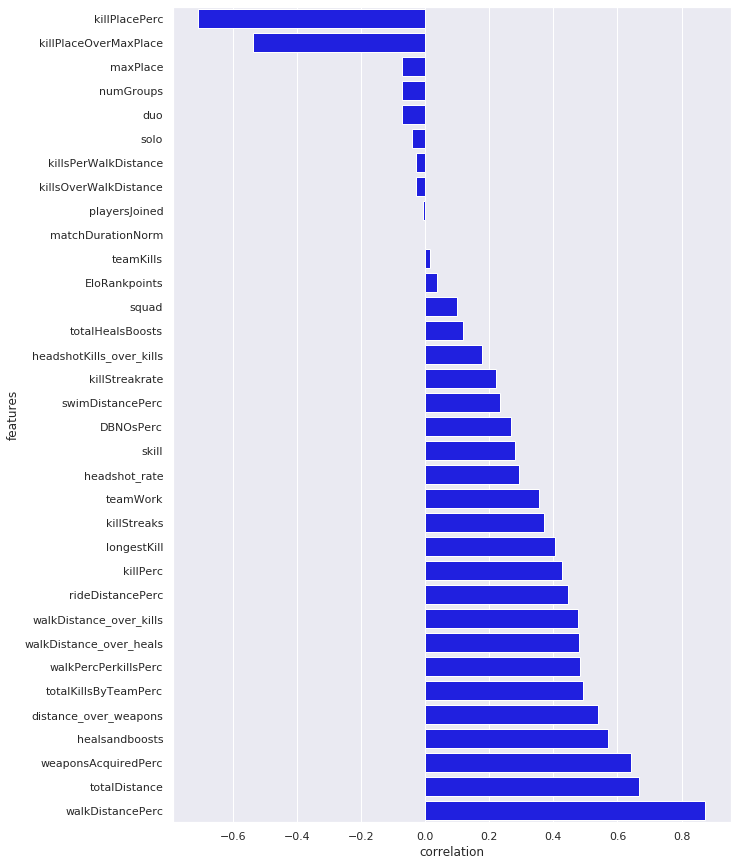

time: 696 ms


In [0]:
sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x="correlation", y="features", data=df,
          label="Feature Important", color="blue")
plt.show()

In [0]:
del df
gc.collect()

9368

time: 94.8 ms
